In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import salem
import xarray as xr
# Some defaults
cmap = plt.get_cmap('RdBu_r')
import ipdb
from utils import constants as cnst, u_darrays as uda
import shapely.geometry as shpg
from scipy.stats import gaussian_kde, linregress

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [42]:
chirps = '/media/ck/Elements/SouthAmerica/CHIRPS/SA_daily_onERA/*.nc'
fpath = cnst.network_data + 'figs/HUARAZ/'

isbuffer = [-78, -61, -20, -8]
topog = [-78,-61,-20,10]
ca = xr.open_mfdataset(chirps).sel(longitude=slice(isbuffer[0], isbuffer[1]), latitude=slice(isbuffer[2], isbuffer[3])).load()
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(topog[0], topog[1]), lat=slice(topog[2], topog[3]))

# This masks out the data which is not in the region
topo_on_ca = ca.salem.lookup_transform(topo)
ca = ca.where(topo_on_ca>2000)

In [43]:
ca = ca.sel(time=(ca['time.year']>=1985) & (ca['time.year']<=2018)&  ((ca['time.month']>=10) | (ca['time.month']<=4)))

In [44]:
ca

<xarray.Dataset>
Dimensions:    (latitude: 49, longitude: 69, time: 7216)
Coordinates:
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2018-12-31
  * longitude  (longitude) float32 -78.0 -77.75 -77.5 ... -61.5 -61.25 -61.0
  * latitude   (latitude) float32 -20.0 -19.75 -19.5 -19.25 ... -8.5 -8.25 -8.0
Data variables:
    precip     (time, latitude, longitude) float32 nan nan nan ... nan nan nan

In [45]:
def readERA(file):

    u200orig = xr.open_dataarray(file)
    #u200orig = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/v850_15UTC_1981-2019_peru_big.nc')
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [115]:
u200 = readERA('/media/ck/Elements/SouthAmerica/ERA5/hourly/u200_15UTC_1981-2019_peru_big.nc')
isvalley = [-78, -61, -18, -15]#[-78, -65, -20, -12.5]
#isjet = [-69,-65,-14,-11] 
isjet = [-70,-61,-17,-12]
#isjet = [-75.5,-74.5,-8.5,-6.5]
u200 = u200.where(topo_on_ca>=2000).sel(longitude=slice(isvalley[0], isvalley[1]), latitude=slice(isvalley[2], isvalley[3])).mean(['latitude', 'longitude'])  #(longitude=slice(isvalley[0], isvalley[1]), latitude=slice(isvalley[2], isvalley[3]))
u850s = readERA('/media/ck/Elements/SouthAmerica/ERA5/hourly/u850_15UTC_1981-2021_peru_big.nc').where(topo_on_ca<=500)
v850s = readERA('/media/ck/Elements/SouthAmerica/ERA5/hourly/v850_15UTC_1981-2019_peru_big.nc').where(topo_on_ca<=500)
q850s = readERA('/media/ck/Elements/SouthAmerica/ERA5/hourly/q850_15UTC_1981-2019_peru_big.nc').where(topo_on_ca<=500)
r850s = readERA('/media/ck/Elements/SouthAmerica/ERA5/hourly/r850_15UTC_1981-2021_peru_big.nc').where(topo_on_ca<=500)
u850 = u850s.sel(longitude=slice(isjet[0], isjet[1]), latitude=slice(isjet[2], isjet[3])).mean(['latitude', 'longitude'])#.rolling(time=3, min_periods=1, center=True).mean()#.quantile(0.99, ['latitude', 'longitude'])
q850 = q850s.sel(longitude=slice(isjet[0], isjet[1]), latitude=slice(isjet[2], isjet[3])).mean(['latitude', 'longitude'])
v850 = v850s.sel(longitude=slice(isjet[0], isjet[1]), latitude=slice(isjet[2], isjet[3])).mean(['latitude', 'longitude'])
r850 = r850s.sel(longitude=slice(isjet[0], isjet[1]), latitude=slice(isjet[2], isjet[3])).mean(['latitude', 'longitude'])

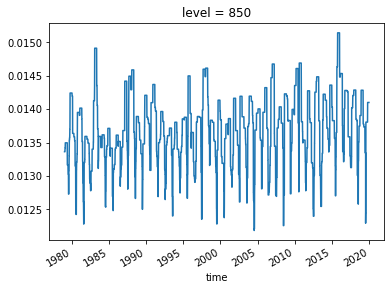

In [116]:
q850.rolling(time=100, min_periods=1, center=True).max().plot()

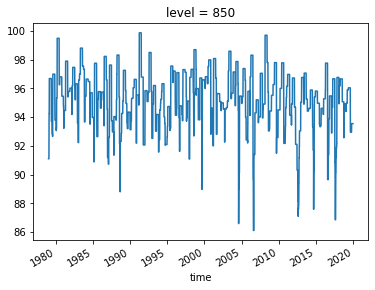

In [117]:
r850.rolling(time=100, min_periods=1, center=True).max().plot()

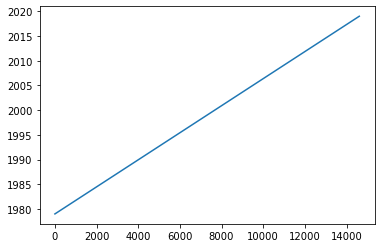

In [118]:
plt.plot(u850.rolling(time=120, min_periods=30, center=True).mean().time.values)

In [119]:
ca

<xarray.Dataset>
Dimensions:    (latitude: 49, longitude: 69, time: 7216)
Coordinates:
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2018-12-31
  * longitude  (longitude) float32 -78.0 -77.75 -77.5 ... -61.5 -61.25 -61.0
  * latitude   (latitude) float32 -20.0 -19.75 -19.5 -19.25 ... -8.5 -8.25 -8.0
Data variables:
    precip     (time, latitude, longitude) float32 nan nan nan ... nan nan nan

/home/ck/miniconda3/lib/python3.7/site-packages/descartes/patch.py:87: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return PathPatch(PolygonPath(polygon), **kwargs)


{'imshow': <matplotlib.image.AxesImage at 0x7f0e0c5babd0>,
 'contour': [<matplotlib.contour.QuadContourSet at 0x7f0e0c6aba90>],
 'contourf': []}

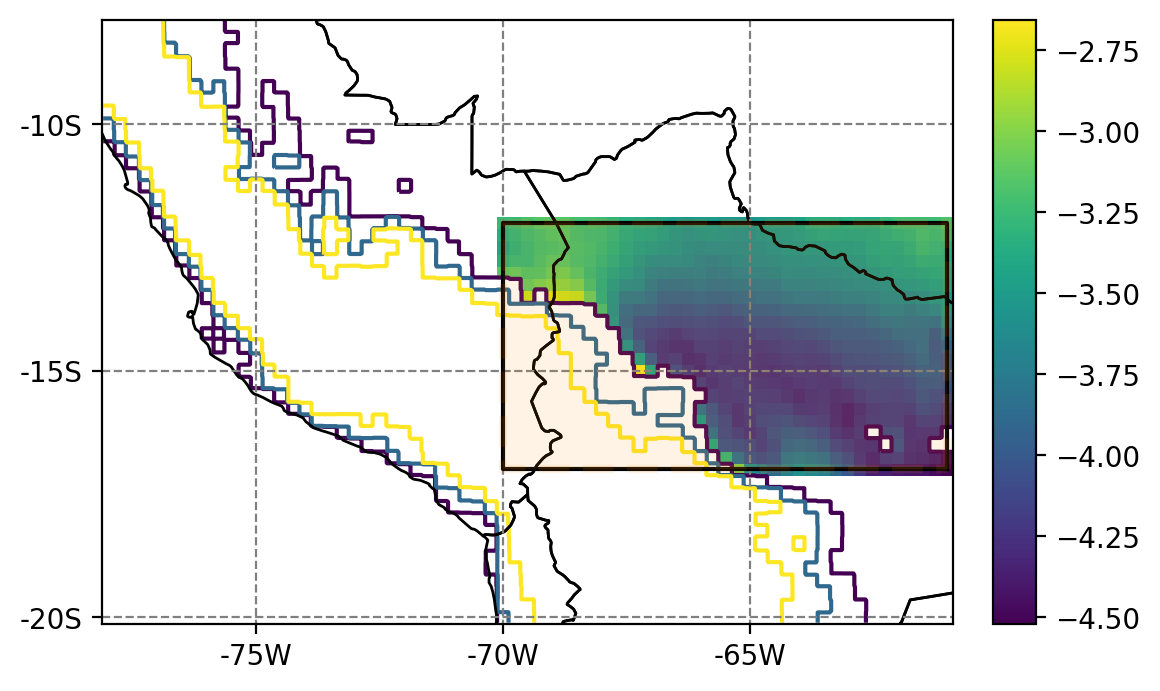

In [120]:
map = v850s.salem.get_map()
f = plt.figure(figsize=(7,4), dpi=200)

ax = f.add_subplot(111)

map.set_data(v850s.sel(longitude=slice(isjet[0], isjet[1]), latitude=slice(isjet[2], isjet[3])).mean('time'))
map.set_contour(topo_on_ca, levels=[500,1000,2000]) #topo_on_ca
coord = isjet
geom = shpg.box(coord[0], coord[2], coord[1], coord[3])
map.set_geometry(geom, zorder=99, color='darkorange', linewidth=3, linestyle='--', alpha=0.1)
map.visualize()


In [121]:
ca_rainy = ca['precip'].sel(longitude=slice(isvalley[0], isvalley[1]), latitude=slice(isvalley[2], isvalley[3])).mean(['latitude', 'longitude'])
#ca_rainy = ca_rainy.where(ca_rainy>0.1, drop=True)

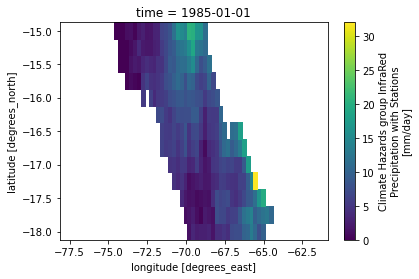

In [122]:
(ca['precip'].sel(longitude=slice(isvalley[0], isvalley[1]), latitude=slice(isvalley[2], isvalley[3])))[0,:,:].plot()

In [123]:
np.unique(ca_rainy['time.year']).shape

(34,)

In [124]:
ca_rainy.shape

(7216,)

In [125]:
ca_rainy = ca_rainy[(ca_rainy['time.month']>=10) | (ca_rainy['time.month']<=4)]

posgrid3 = np.intersect1d(v850.time.values, u200.time.values)
u200era = u200.sel(time=posgrid3)

posgrid200 = np.intersect1d(u200era.time.values, ca_rainy.time.values)
u200ca = u200era.sel(time=posgrid200)

posgrid850 = np.intersect1d(v850.time.values, u200ca.time.values)
v850ca = v850.sel(time=posgrid850)

posgrid850 = np.intersect1d(u850.time.values, u200ca.time.values)
u850ca = u850.sel(time=posgrid850)

posgrid850 = np.intersect1d(q850.time.values, u200ca.time.values)
q850ca = q850.sel(time=posgrid850)

posgrid850 = np.intersect1d(r850.time.values, u200ca.time.values)
r850ca = q850.sel(time=posgrid850)

In [126]:
print(np.unique(u200ca['time.year']).shape, np.unique(v850ca['time.year']).shape, np.unique(u850ca['time.year']).shape, np.unique(q850ca['time.year']).shape,  np.unique(ca_rainy['time.year']).shape)

(34,) (34,) (34,) (34,) (34,)


In [127]:
def create_2dhist(x,y,z, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outval = np.zeros((len(ybins),len(xbins)))
    outdat = np.zeros((len(ybins),len(xbins)))

    for isq, qql in enumerate(ybins[0:-1]):

        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (x >= shl) & (x < xbins[issh+1]) & (y>=qql) & (y < ybins[isq+1])
                
            try:
                prcp_mmean = np.nansum(z[poss_ds]) ##np.percentile(ds.prcp[poss_ds], 50)
                prcp_val = np.sum(np.isfinite(z[poss_ds]))
                if prcp_val < 5:
                    prcp_mean = np.nan
                else:
                    prcp_mean = prcp_mmean/prcp_val  
            except:
                prcp_mean = np.nan
            #ipdb.set_trace()
            outval[isq,issh] = prcp_val
            outdat[isq,issh] = prcp_mean
            
    return outdat, outval

In [128]:
uqdat, uqval = create_2dhist(u200ca,q850ca*1000,ca_rainy, np.arange(-15,16), np.arange(6,15))

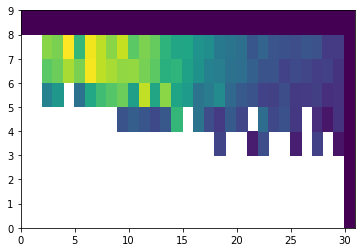

In [129]:
plt.pcolormesh(uqdat)

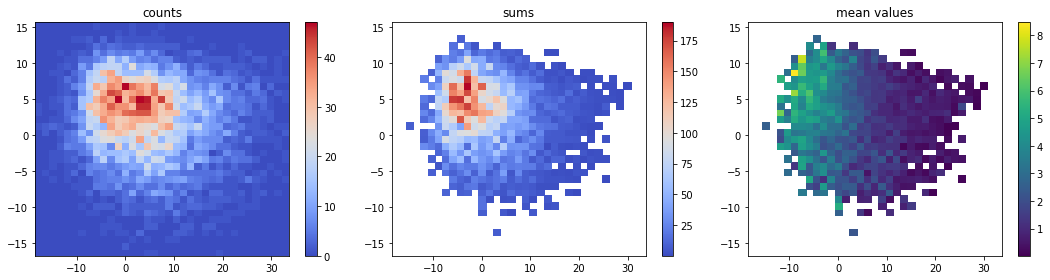

In [144]:
import numpy as np
import matplotlib.pyplot as plt

x = u200ca
y = u850ca#*1000
z = ca_rainy

counts, xbins, ybins = np.histogram2d(x, y, bins=(35, 35))
sums, _, _ = np.histogram2d(x, y, weights=z, bins=(xbins, ybins))

sums[counts<3] = np.nan

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 4))
m1 = ax1.pcolormesh(xbins, ybins, counts.T, cmap='coolwarm')
plt.colorbar(m1, ax=ax1)
ax1.set_title('counts')
m2 = ax2.pcolormesh(xbins, ybins, sums.T, cmap='coolwarm')
plt.colorbar(m2, ax=ax2)
ax2.set_title('sums')
with np.errstate(divide='ignore', invalid='ignore'):  # suppress possible divide-by-zero warnings
    m3 = ax3.pcolormesh(xbins, ybins, (sums / counts).T, cmap='viridis')
plt.colorbar(m3, ax=ax3)
ax3.set_title('mean values')
plt.tight_layout()
plt.show()

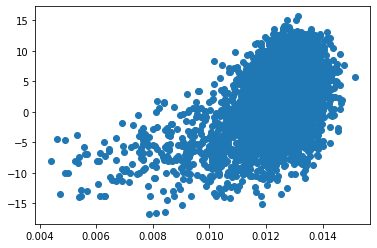

In [131]:
plt.scatter(q850ca, u850ca)

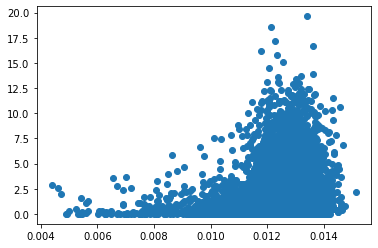

In [132]:
plt.scatter(q850ca, ca_rainy)

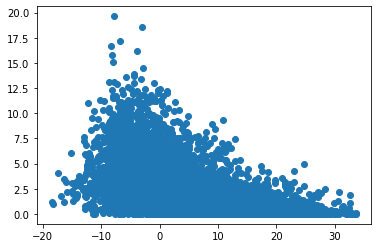

In [133]:
plt.scatter(u200ca,ca_rainy)

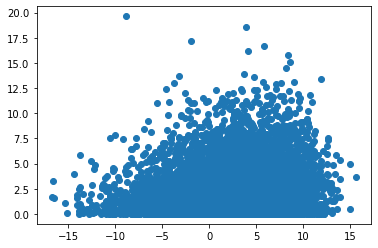

In [134]:
plt.scatter(u850ca,ca_rainy)

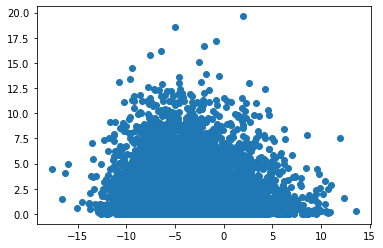

In [135]:
plt.scatter(v850ca,ca_rainy)

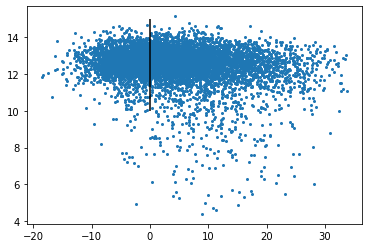

In [136]:
plt.scatter(u200ca,q850ca*1000, s=4)
plt.vlines(0, ymin=10, ymax=15, color='k')
#plt.hlines(0, xmin=-10, xmax=20, color='k')

In [137]:
np.all(u200ca.time==v850ca.time)

<xarray.DataArray 'time' ()>
array(True)

In [69]:
def perc_1d_binning(xvar, data, xbins):
    import warnings
    """
    :param xvar: xvar of the 2dhist
    :param yvar: yvar of the 2d hist
    :param xbins: bins to use for the xvar
    :param ybins: bins to use for the yvar
    :param varlist: dictionary of variables to put into histogram
    :param varpick: list of variables in dic to calculate
    :return:
    """
    outdic = {}
    outdic['data'] = []


    for issh, shl in enumerate(xbins[0:-1]):

        poss_ds = (xvar > shl) & (xvar <= xbins[issh + 1])
        valdat = (data[poss_ds])[np.isfinite(data[poss_ds])]
        #dat = np.percentile(valdat, perc)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            dat = np.nanmean(valdat)
        #ipdb.set_trace()
        outdic['data'].append(dat)

        #ipdb.set_trace()

    outdic['xbins'] = (np.round(xbins[0:-1]+((xbins[1::]-xbins[0:-1])/2),2))


    return outdic

In [70]:

def binning_loop(x, y, ranges=np.arange(-15,16,1)):
    dic = {'corr': [], 'pval' : [], 'slope' : []}
    f = plt.figure(figsize=(15,9), dpi=200)
    for ids,year in enumerate(range(1985,2019)):

        xx = x.sel(time=slice(str(year-1)+'-09-01',str(year)+'-04-30'))
        yy = y.sel(time=slice(str(year-1)+'-09-01',str(year)+'-04-30'))
        
        #ipdb.set_trace()

        cadic = perc_1d_binning(xx,yy, xbins=ranges)
        isval = np.isfinite(cadic['data'])
        b, a, r_value, p_value, std_err = linregress(np.array(cadic['xbins'])[isval],np.array(cadic['data'])[isval])
        
#         isval = np.isfinite(xx) & np.isfinite(yy)
#         b, a, r_value, p_value, std_err = linregress(np.array(xx)[isval],np.array(yy)[isval])
        #ipdb.set_trace()
        ax = f.add_subplot(7,5,ids+1)
        ax.scatter(cadic['xbins'], cadic['data'])
        ax.plot(cadic['xbins'], a+cadic['xbins']*b, color='k', linestyle='dashed', linewidth=1)
        plt.title(str(year)+' | r: '+str(np.round(r_value,2)))
    
       # ipdb.set_trace()
        dic['corr'].append(r_value)
        dic['pval'].append(p_value)
        dic['slope'].append(b)
    plt.tight_layout()                        
    return dic, np.unique(xx['time.year'])

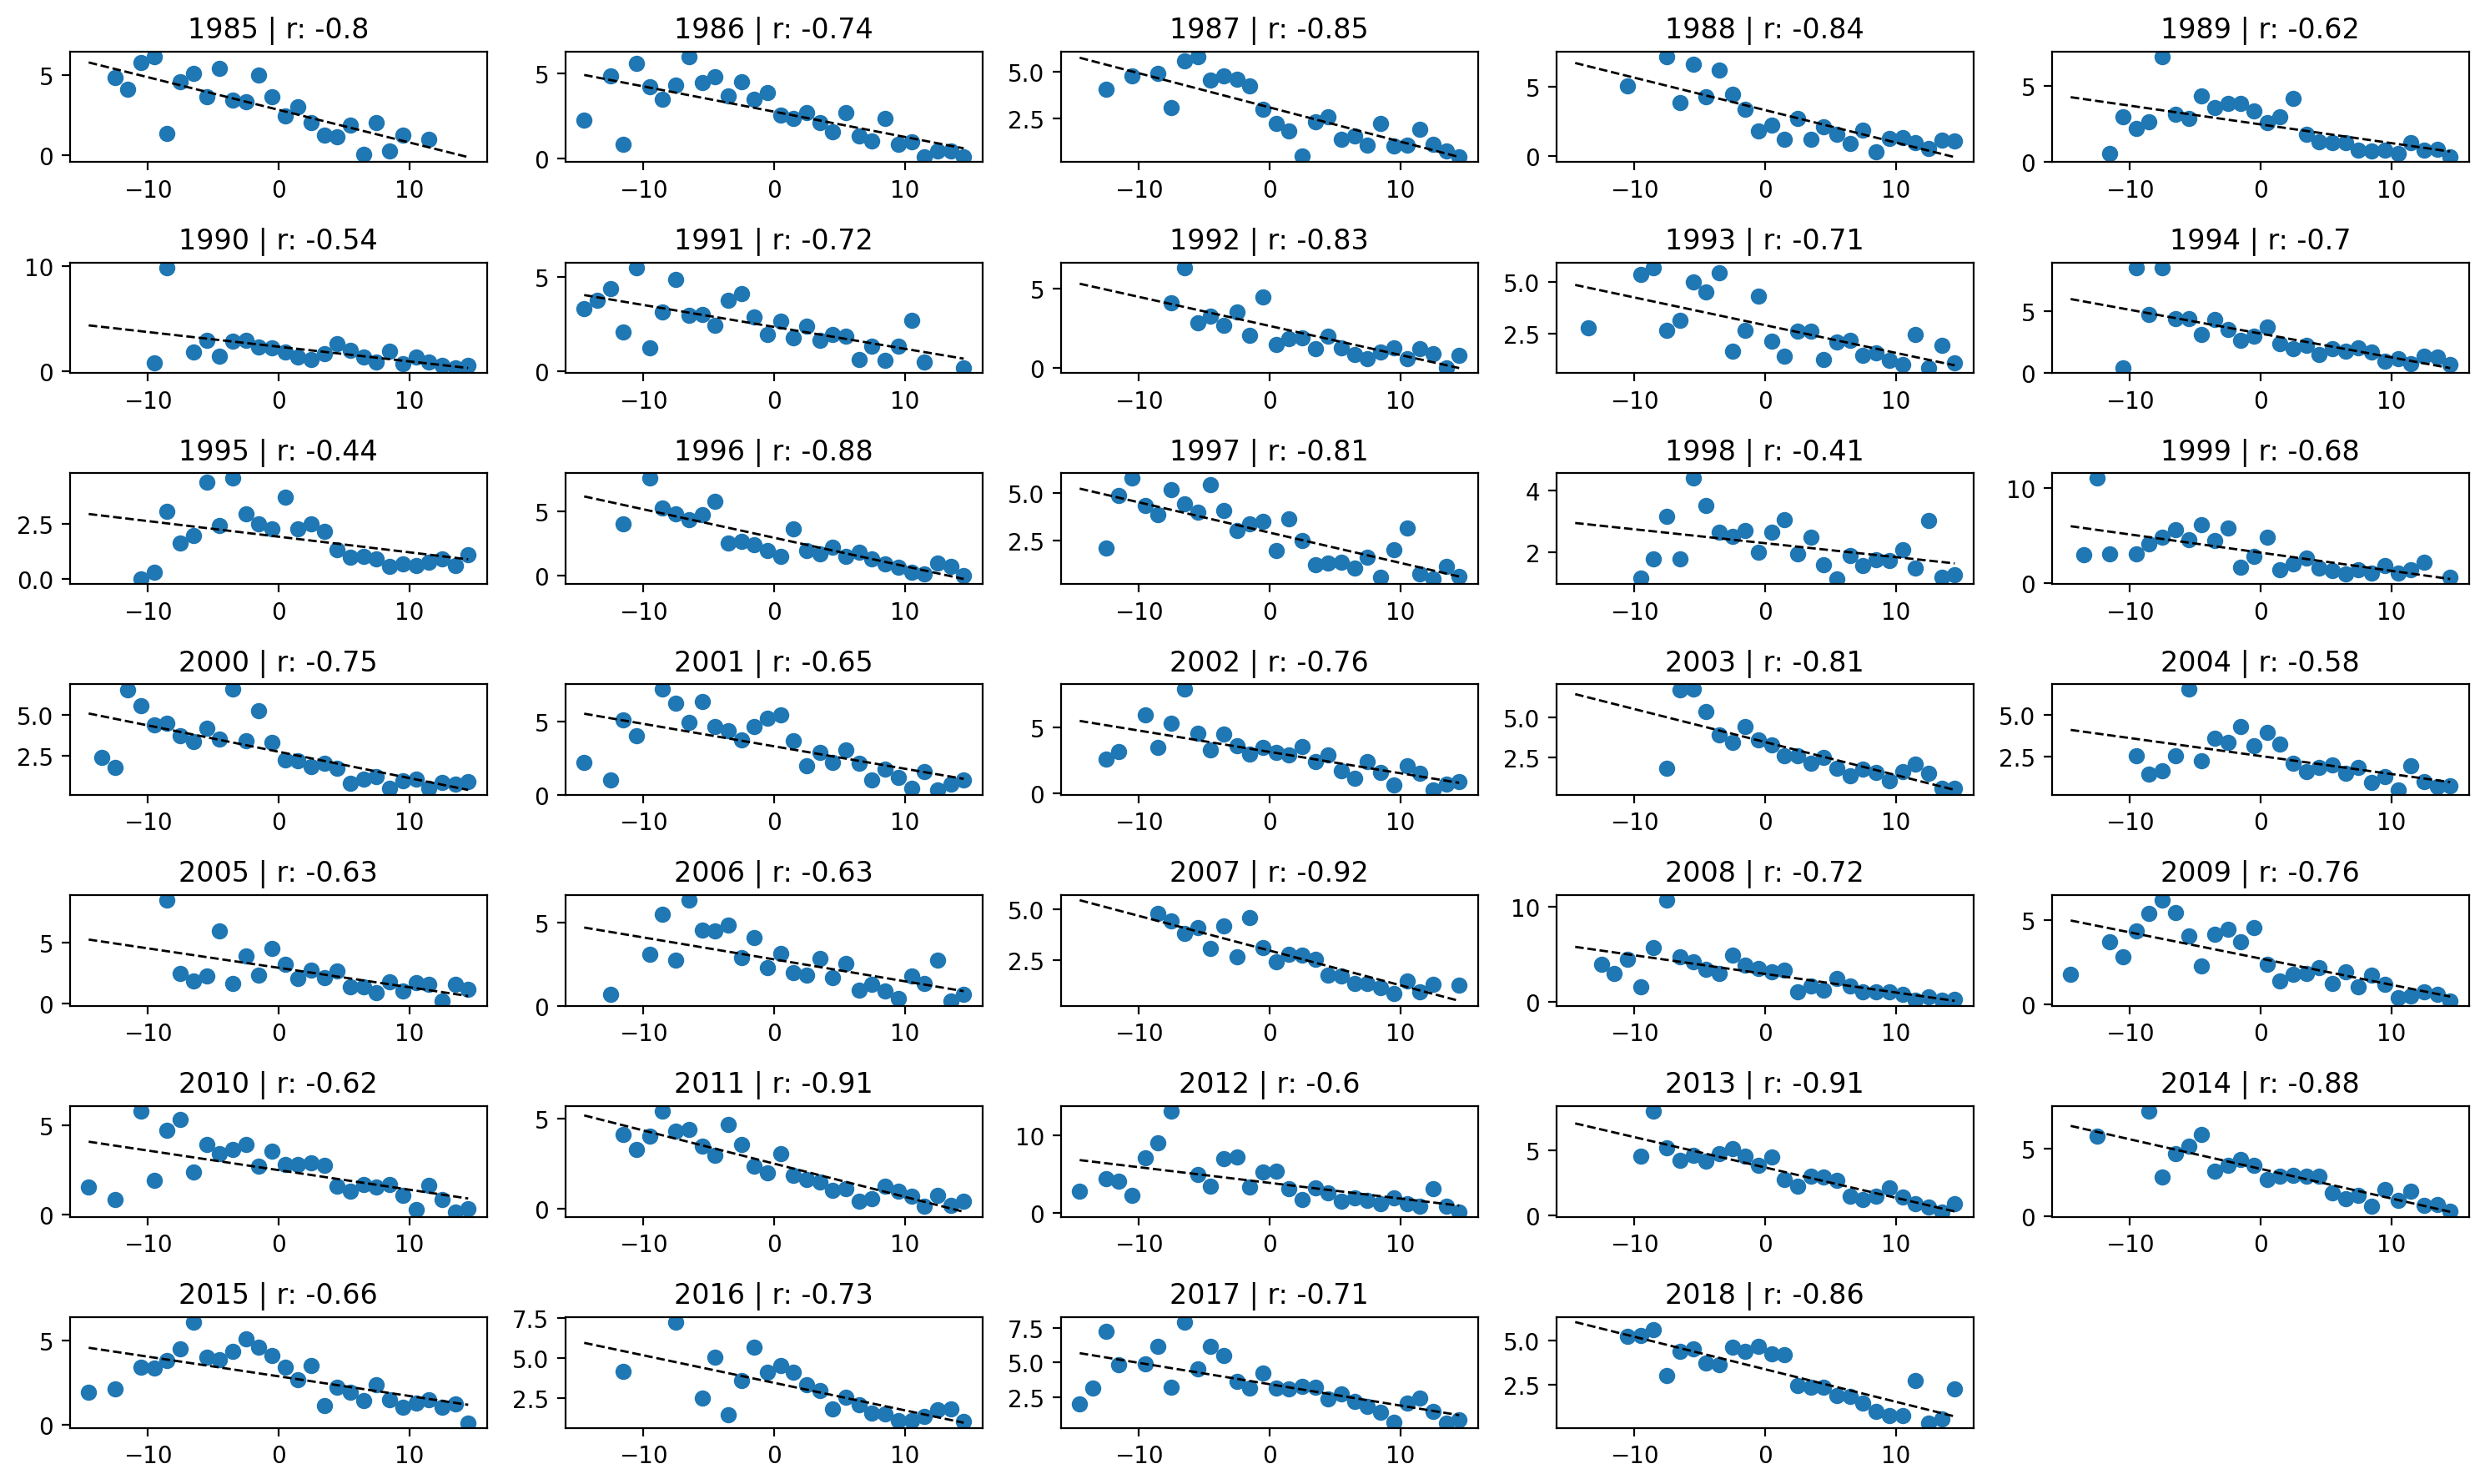

In [71]:
u200_stats, years = binning_loop(u200ca, ca_rainy)

In [72]:
years = np.arange(1985,2019)

In [73]:
len(years)

34

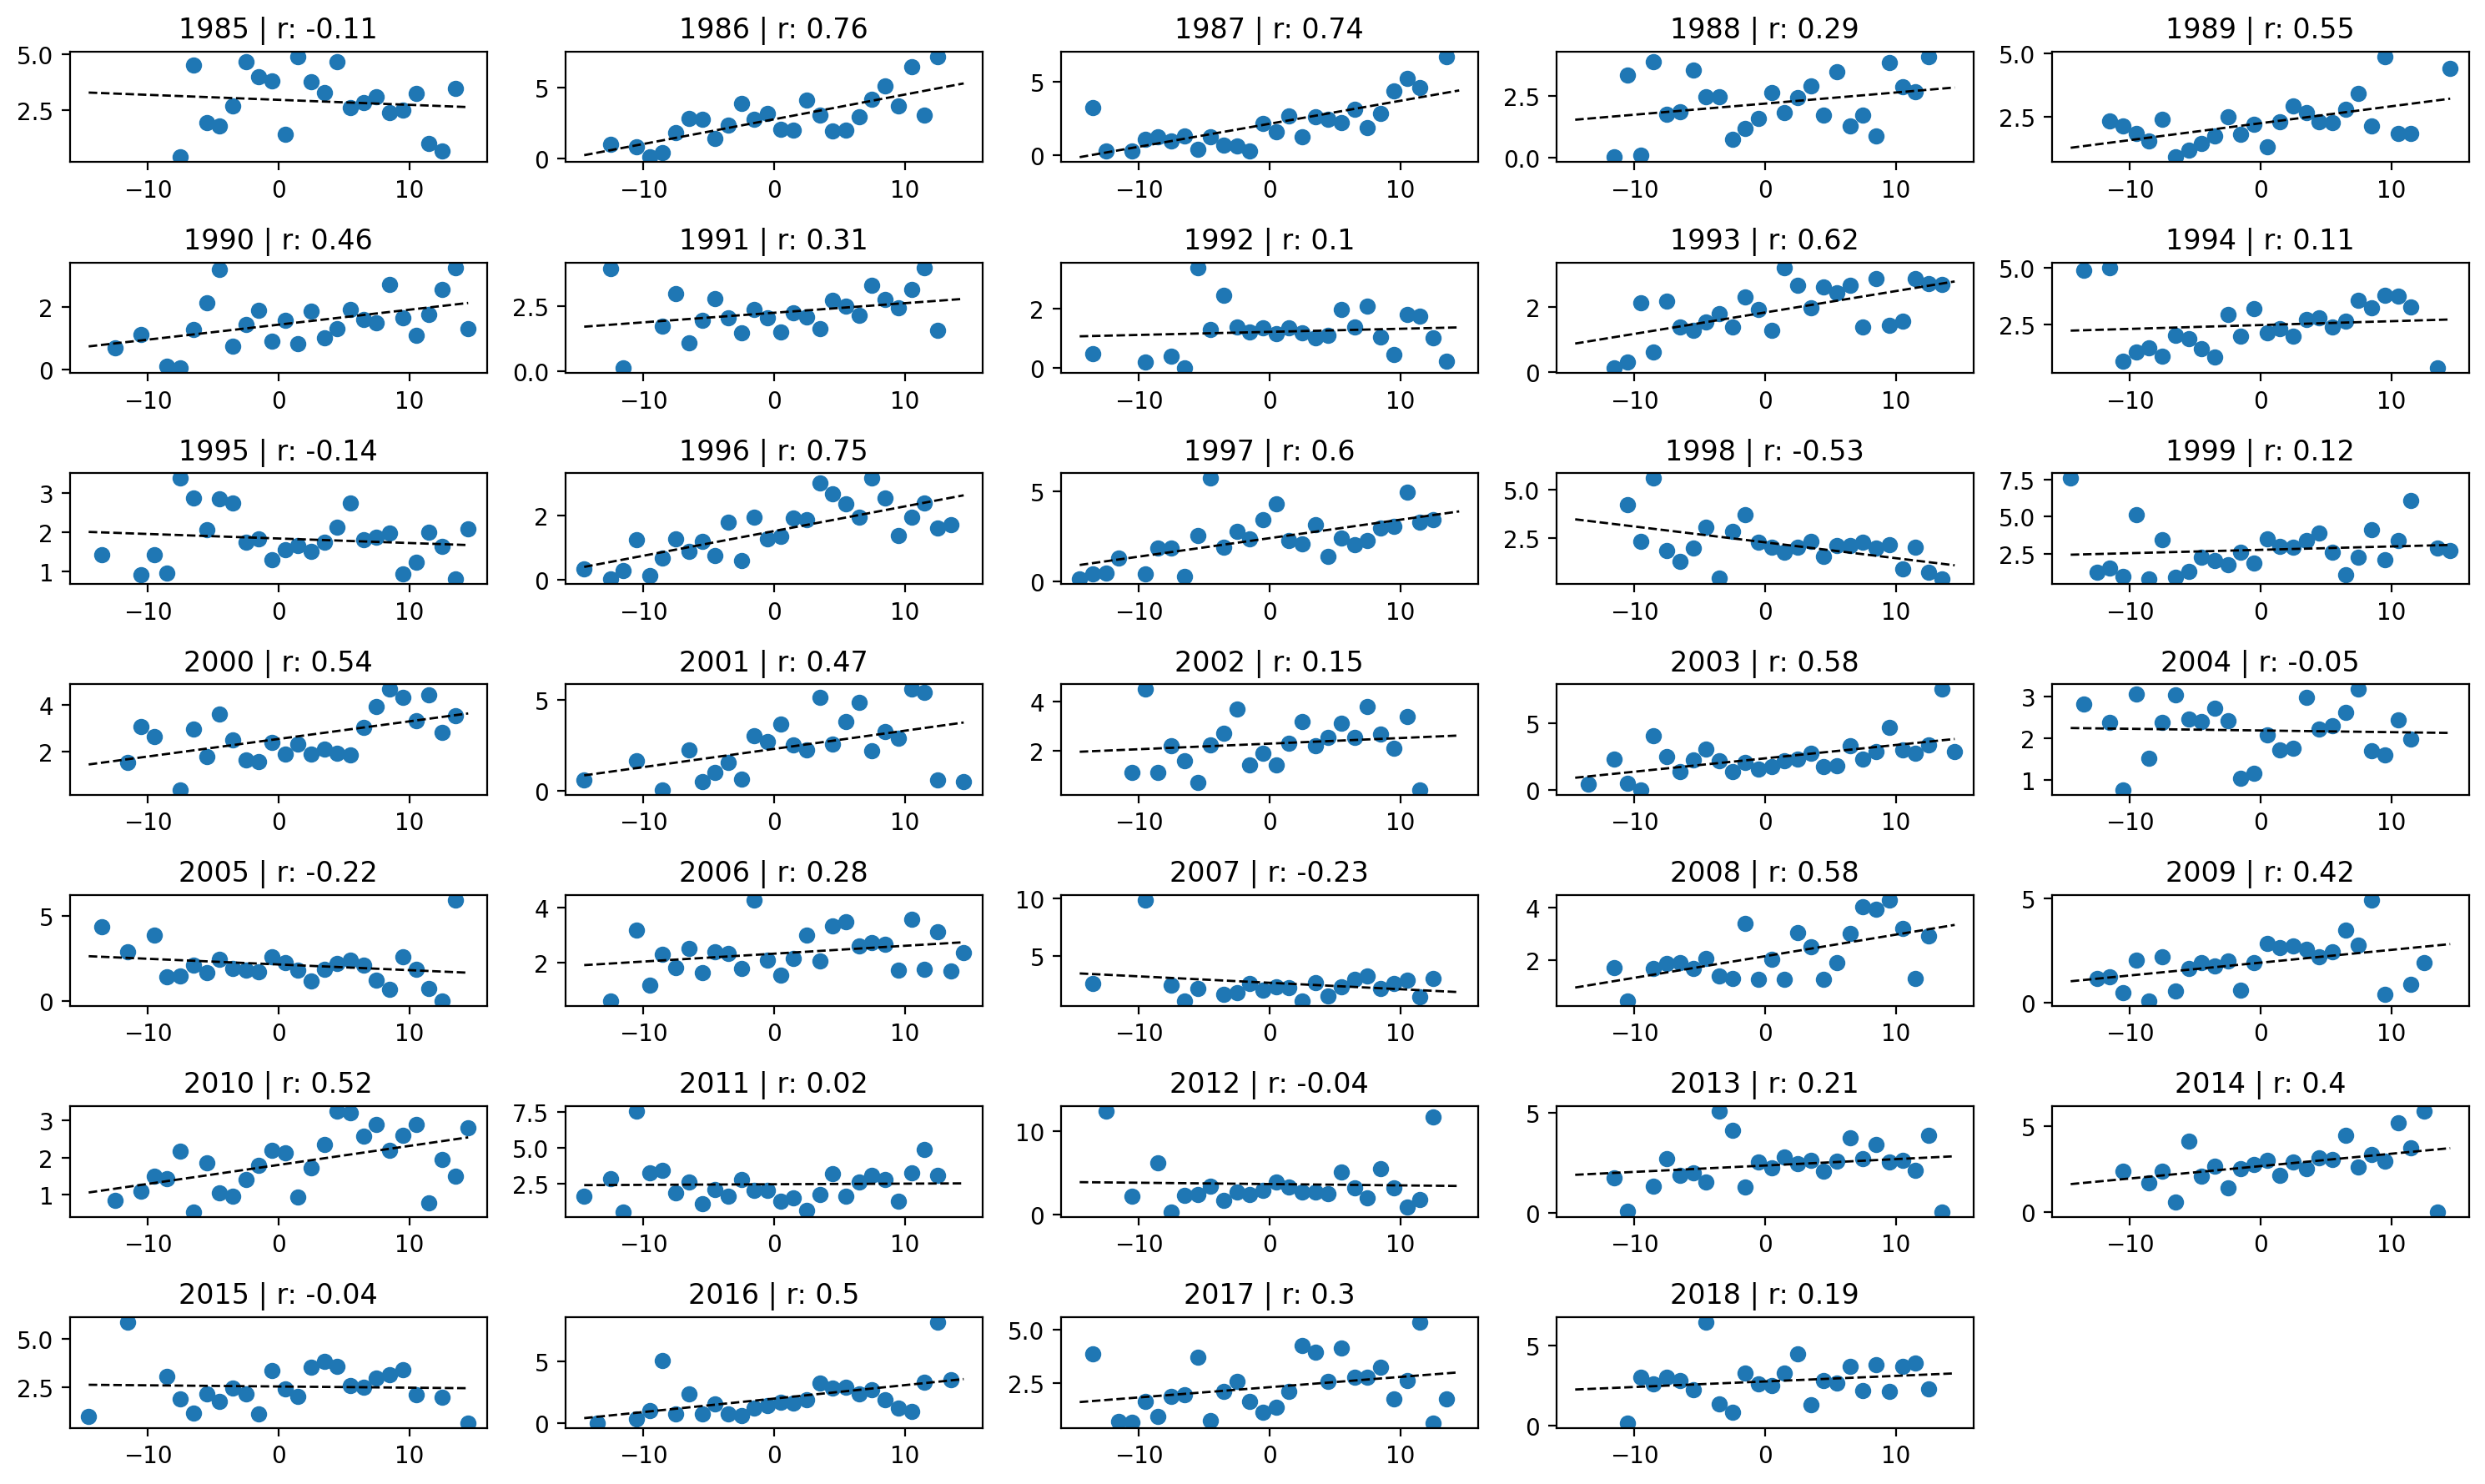

In [74]:
v850_stats, years = binning_loop(u850ca, ca_rainy)

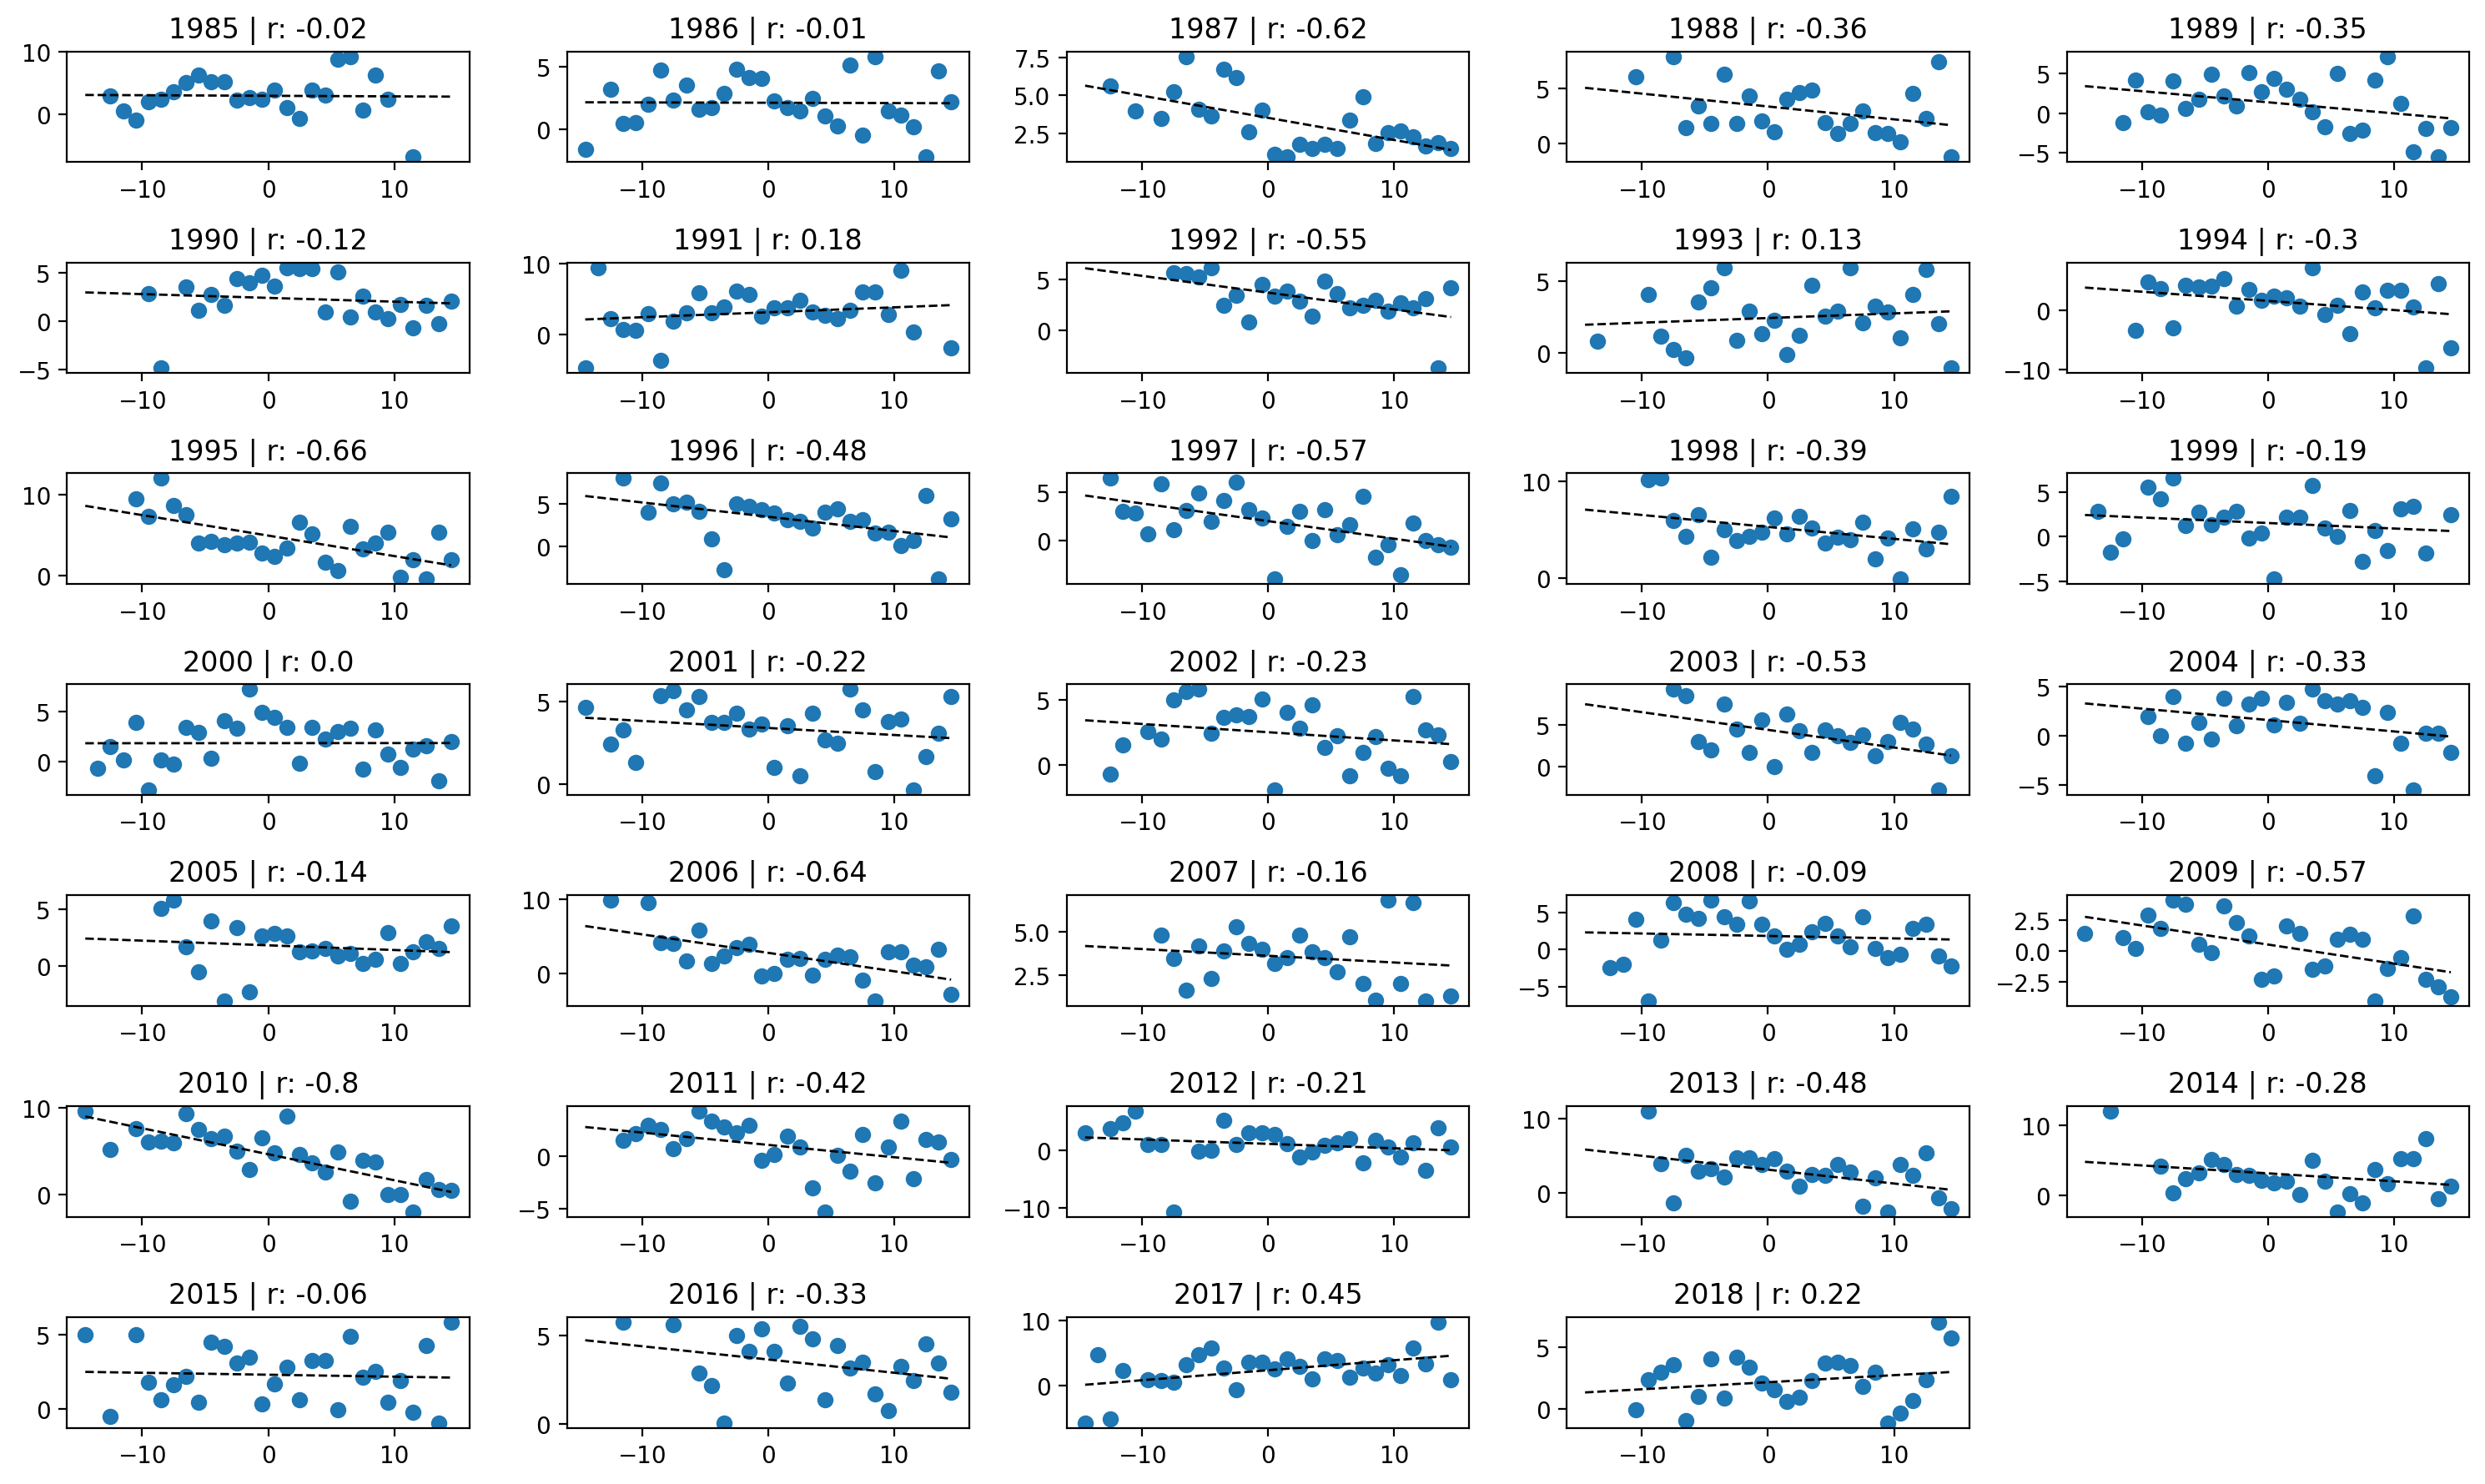

In [75]:
wind_stats, years = binning_loop(u200ca, u850ca)

In [76]:
# # f = plt.figure(figsize=(15,12), dpi=300)
# u200_stats = {'corr': [], 'pval' : [], 'slope' : []}

# for ids,y in enumerate(range(1983,2019)):
#     cadic = perc_1d_binning(cau200[cau200['time.year']==y], u200ca[u200ca['time.year']==y], xbins=np.arange(-15,15,1))
#     isval = np.isfinite(cadic['data'])
#     b, a, r_value, p_value, std_err = linregress(np.array(cadic['xbins'])[isval],np.array(cadic['data'])[isval])

# #     ax = f.add_subplot(9,4,ids+1)
# #     ax.scatter(cadic['xbins'], cadic['data'])
# #     ax.plot(cadic['xbins'], a+cadic['xbins']*b, color='k', linestyle='dashed', linewidth=1)
# #    plt.title(str(y)+' | r: '+str(np.round(r_value,2)))
#     u200_stats['corr'].append(r_value)
#     u200_stats['pval'].append(p_value)
#     u200_stats['slope'].append(b)

In [77]:
# #f = plt.figure(figsize=(15,12), dpi=300)
# v850_stats = {'corr': [], 'pval' : [], 'slope' : []}
# for ids,y in enumerate(range(1983,2019)):
#     cadic = perc_1d_binning(cav850[cav850['time.year']==y], v850ca[v850ca['time.year']==y], xbins=np.arange(-15,15,1))
#     isval = np.isfinite(cadic['data'])
#     b, a, r_value, p_value, std_err = linregress(np.array(cadic['xbins'])[isval],np.array(cadic['data'])[isval])

# #     ax = f.add_subplot(9,4,ids+1)
# #     ax.scatter(cadic['xbins'], cadic['data'])
# #     ax.plot(cadic['xbins'], a+cadic['xbins']*b, color='k', linestyle='dashed', linewidth=1)
# #    plt.title(str(y)+' | r: '+str(np.round(r_value,2)))
#     v850_stats['corr'].append(r_value)
#     v850_stats['pval'].append(p_value)
#     v850_stats['slope'].append(b)

In [78]:
# #f = plt.figure(figsize=(15,12), dpi=300)
# wind_stats = {'corr': [], 'pval' : [], 'slope' : []}
# for ids,y in enumerate(range(1983,2019)):
#     cadic = perc_1d_binning(u200ca[u200ca['time.year']==y], v850ca[v850ca['time.year']==y], xbins=np.arange(-15,15,1))
#     isval = np.isfinite(cadic['data'])
#     b, a, r_value, p_value, std_err = linregress(np.array(cadic['xbins'])[isval],np.array(cadic['data'])[isval])

# #     ax = f.add_subplot(9,4,ids+1)
# #     ax.scatter(cadic['xbins'], cadic['data'])
# #     ax.plot(cadic['xbins'], a+cadic['xbins']*b, color='k', linestyle='dashed', linewidth=1)
# #    plt.title(str(y)+' | r: '+str(np.round(r_value,2)))
#     wind_stats['corr'].append(r_value)
#     wind_stats['pval'].append(p_value)
#     wind_stats['slope'].append(b)

In [79]:
years = np.unique(u200ca['time.year'])
len(years)

34

In [80]:
years=years[3::]

In [81]:
years2 = np.unique(u200era['time.year'])

In [82]:
len(years)

31

In [83]:
years2 = np.arange(1985,2019)

Text(0.5, 1.0, 'Altiplano: CHIRPS & wind daily correlation Sep-April')

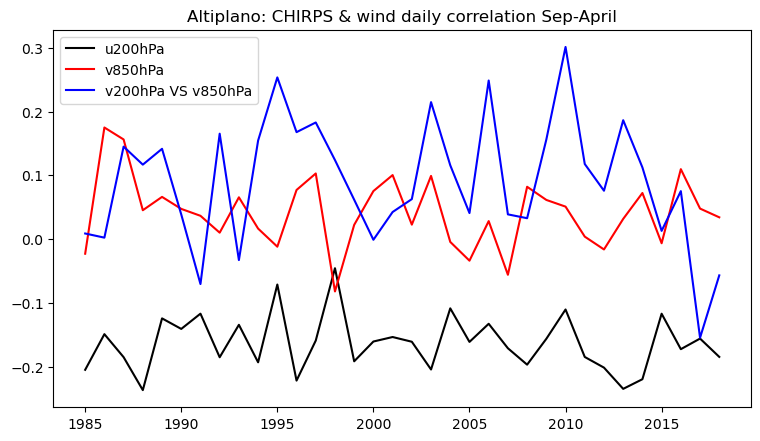

In [84]:
f = plt.figure(figsize=(9,5), dpi=100)
ax = f.add_subplot(111)

# valpos2 = np.array(u200_stats['pval'])<0.05
# xval2  = (years2)[valpos2]
# yval2 = np.array(u200_stats['corr'])[valpos2]

# valpos8 = np.array(v850_stats['pval'])<0.05
# xval8  = (years2)[valpos8]
# yval8 = np.array(v850_stats['corr'])[valpos8]

# valposw = np.array(wind_stats['pval'])<0.05
# xvalw  = (years2)[valposw]
# yvalw = np.array(wind_stats['corr'])[valposw]

plt.plot(years2,u200_stats['slope'], linestyle='-', color='k', label='u200hPa')
plt.plot(years2,v850_stats['slope'], linestyle='-', color='r', label='v850hPa')
plt.plot(years2,np.array(wind_stats['slope'])*(-1), linestyle='-', color='b', label = 'v200hPa VS v850hPa')
                                     
# plt.plot(xval2,yval2, marker='o', linestyle='', color='k')
# plt.plot(xval8,yval8, marker='o', linestyle='', color='r')
# plt.plot(xvalw,yvalw*-1, marker='o', linestyle='', color='b')
plt.legend()
plt.title('Altiplano: CHIRPS & wind daily correlation Sep-April')
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/correlation_timeseries_Altiplano_Chirps.jpg')

Text(0.5, 1.0, 'Altiplano: CHIRPS & wind daily correlation Sep-April')

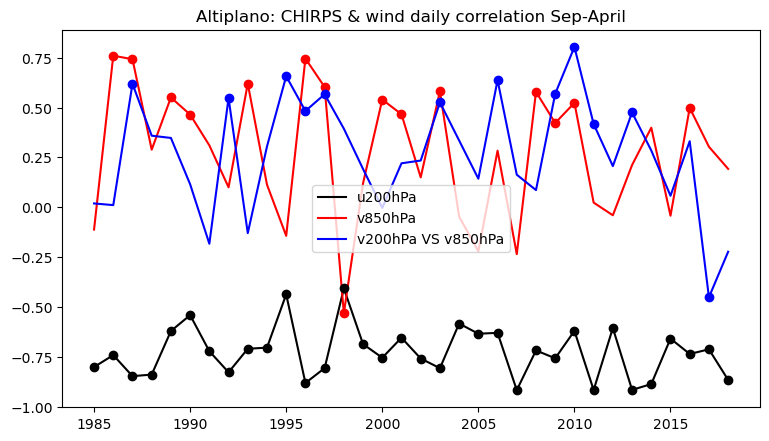

In [85]:
f = plt.figure(figsize=(9,5), dpi=100)
ax = f.add_subplot(111)

valpos2 = np.array(u200_stats['pval'])<0.05
xval2  = (years2)[valpos2]
yval2 = np.array(u200_stats['corr'])[valpos2]

valpos8 = np.array(v850_stats['pval'])<0.05
xval8  = (years2)[valpos8]
yval8 = np.array(v850_stats['corr'])[valpos8]

valposw = np.array(wind_stats['pval'])<0.05
xvalw  = (years2)[valposw]
yvalw = np.array(wind_stats['corr'])[valposw]

plt.plot(years2,u200_stats['corr'], linestyle='-', color='k', label='u200hPa')
plt.plot(years2,v850_stats['corr'], linestyle='-', color='r', label='v850hPa')
plt.plot(years2,np.array(wind_stats['corr'])*(-1), linestyle='-', color='b', label = 'v200hPa VS v850hPa')
                                     
plt.plot(xval2,yval2, marker='o', linestyle='', color='k')
plt.plot(xval8,yval8, marker='o', linestyle='', color='r')
plt.plot(xvalw,yvalw*-1, marker='o', linestyle='', color='b')
plt.legend()
plt.title('Altiplano: CHIRPS & wind daily correlation Sep-April')
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/correlation_timeseries_Altiplano_Chirps.jpg')